### Pre-installs

In [1]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install seaborn
# %pip install sklearn
# %pip install -U scikit-learn
# %pip install spotipy

### Input your data here

In [2]:
input_song = input("Enter your desired song name here!")
input_playlist = input("Enter your desired playlist name here!s")
recc_num = int(input("Enter how many songs you want to be recommended!"))
client_id = input("Enter your Spotify API Client Key here!")
client_secret = input("Enter your Spotify API Secret Key here!")

### CSV & Spotify Information

In [3]:
import pandas as pd
import ast

# Importing the datasets
dataset = pd.read_csv("data/tracks_with_genres.csv")
df = pd.read_csv("data/tracks.csv")

# Creating the dataframe
df_generated = pd.DataFrame(dataset)
df_generated['genres'] = df_generated['genres'].apply(ast.literal_eval)

In [4]:
# Spotify API Authentication Information
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
# api key
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                               client_secret=client_secret,
                                               redirect_uri="http://localhost/",
                                               scope="playlist-modify-private",
                                               show_dialog=True,
                                               cache_path="token.txt"
                                               ))

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# # Assuming df_generated is your DataFrame
# # Adjust this part based on your actual DataFrame structure
# # For example, you might need to select specific columns or rows
# # or convert categorical variables to numerical values for visualization

# df_generated.columns
# df_graph = df_generated[['popularity', 'duration_ms', 'explicit',
#        'danceability', 'energy', 'key', 'loudness',
#        'speechiness', 'acousticness', 'instrumentalness', 'liveness',
#        'valence', 'tempo', 'time_signature']]

# sns.set(style="white")  # Set the style of the plot

# # Create a heatmap using seaborn with annotated values for the entire correlation matrix
# plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
# heatmap = sns.heatmap(df_graph.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# # Customize the appearance of the heatmap
# heatmap.set_title('Heatmap of df_generated', fontsize=16)

# plt.show()

### Processing the Input Song

In [6]:
# Using Spotify API to search for a song's information based on input and adding the necessary information in a DataFrame.
def search_track(track_name):
    # Search for the track
    results = sp.search(q=track_name, type='track')

    # Check if the track exists
    if results['tracks']['total'] > 0:
        # Get the first track from the results
        track = results['tracks']['items'][0]
        explicit = int(track["explicit"] == True)
        print(f'Found track: {track["name"]} by {track["artists"][0]["name"]} from the album {track["album"]["name"]}.')
        track_dict = {"id": track["id"], "name": track["name"], "popularity": track["popularity"], 
                      "duration_ms": track["duration_ms"], "explicit": explicit, "artists": track["artists"][0]["name"],
                      "id_artists": track["artists"][0]["id"], "release_date": track["album"]["release_date"]}
        return track_dict
    else:
        print('Track not found')
        return None

# Creating a Single Row DataFrame for the input song.
track_result = search_track(input_song)
td = pd.DataFrame(track_result, index=[0])
td

Using `localhost` as redirect URI without a port. Specify a port (e.g. `localhost:8080`) to allow automatic retrieval of authentication code instead of having to copy and paste the URL your browser is redirected to.


Found track: Piano Man by Billy Joel from the album Piano Man (Legacy Edition).


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date
0,70C4NyhjD5OZUMzvWZ3njJ,Piano Man,79,339000,0,Billy Joel,6zFYqv1mOsgBRQbae3JJ9e,1973-11-07


In [7]:
# Obtaining Feature Data from song based on its song_id from previous function and adding them to a DataFrame.
def get_audio_features(track_result):
    song_id = track_result["id"]
    results = sp.audio_features(song_id)

    if results:
        return results[0]
    else:
        print(f'No audio features found for song ID: {song_id}')
        return None

audio_features = get_audio_features(track_result)
af = pd.DataFrame(audio_features, index=[0])
# Taking out the irrevelant features.
af_formatted = af.drop(["type", "id", "uri", "track_href", "analysis_url", "duration_ms"], axis=1)
# Merging both DataFrames to sync up with the dataset's layout.
td = pd.concat([td, af_formatted], axis=1)
td['year'] = td['release_date'].str.extract(r'(\d{4})').astype(int)

In [8]:
td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,70C4NyhjD5OZUMzvWZ3njJ,Piano Man,79,339000,0,Billy Joel,6zFYqv1mOsgBRQbae3JJ9e,1973-11-07,0.331,0.55,...,-6.483,1,0.0272,0.605,0.000004,0.192,0.429,177.734,3,1973


In [9]:
import ast

td['artists'] = "['" + td['artists'] + "']"
td['artists'] = td['artists'].apply(ast.literal_eval)

td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,70C4NyhjD5OZUMzvWZ3njJ,Piano Man,79,339000,0,[Billy Joel],6zFYqv1mOsgBRQbae3JJ9e,1973-11-07,0.331,0.55,...,-6.483,1,0.0272,0.605,0.000004,0.192,0.429,177.734,3,1973


In [10]:
td['artists_count'] = len(td['artists'])
td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,artists_count
0,70C4NyhjD5OZUMzvWZ3njJ,Piano Man,79,339000,0,[Billy Joel],6zFYqv1mOsgBRQbae3JJ9e,1973-11-07,0.331,0.55,...,1,0.0272,0.605,0.000004,0.192,0.429,177.734,3,1973,1


In [11]:
expanded_artists = td['artists'].apply(lambda x: pd.Series(x))

# Rename the columns
expanded_artists.columns = [f"artist_{i+1}" for i in range(len(expanded_artists.columns))]

# Concatenate the expanded columns with the original DataFrame
td = pd.concat([td, expanded_artists], axis=1)
td.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,artists_count,artist_1
0,70C4NyhjD5OZUMzvWZ3njJ,Piano Man,79,339000,0,[Billy Joel],6zFYqv1mOsgBRQbae3JJ9e,1973-11-07,0.331,0.55,...,0.0272,0.605,0.000004,0.192,0.429,177.734,3,1973,1,Billy Joel


In [12]:
def get_artist_genres(artist_name):
    try:
        results = sp.search(q='artist:' + artist_name, type='artist')
        genres = results['artists']['items'][0]['genres']
        return genres if genres else []
    except IndexError:
        return []
    
for i in range(len(td['artists_count'])):
    td['genres'] = td['artist_' + str(i+1)].apply(get_artist_genres)

td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,artists_count,artist_1,genres
0,70C4NyhjD5OZUMzvWZ3njJ,Piano Man,79,339000,0,[Billy Joel],6zFYqv1mOsgBRQbae3JJ9e,1973-11-07,0.331,0.55,...,0.605,0.000004,0.192,0.429,177.734,3,1973,1,Billy Joel,"[album rock, classic rock, heartland rock, mel..."


### Adding Input to Dataset and further processing

In [13]:
# Adding the Input Song to the Dataset DataFrame. Added to the very front.
new_df = pd.concat([td, df_generated], ignore_index=True)
new_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,tempo,time_signature,year,artists_count,artist_1,genres,song_name_artist,artist_2,artist_3,artist_4
0,70C4NyhjD5OZUMzvWZ3njJ,Piano Man,79,339000,0,[Billy Joel],6zFYqv1mOsgBRQbae3JJ9e,1973-11-07,0.331,0.550,...,177.734,3,1973,1,Billy Joel,"[album rock, classic rock, heartland rock, mel...",NaN,NaN,NaN,NaN
1,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,56,160187,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.484,0.265,...,113.564,3,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",You'll Never Walk Alone - Mono; 2002 Remaster[...,NaN,NaN,NaN
2,6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,41,159560,0,NaN,['6lH5PpuiMa5SpfjoIOlwCS'],2020-03-13,0.671,0.867,...,120.689,4,2020,1,The Toys,[],A Lover's Concerto['The Toys'],NaN,NaN,NaN
3,6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,41,159560,0,NaN,['6lH5PpuiMa5SpfjoIOlwCS'],2020-03-13,0.671,0.867,...,120.689,4,2020,1,The Toys,[thai pop],A Lover's Concerto['The Toys'],NaN,NaN,NaN
4,4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,40,141987,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.405,0.365,...,104.536,4,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",Ferry Cross the Mersey - Mono; 2002 Remaster['...,NaN,NaN,NaN


In [14]:
new_df['song_id_name'] = new_df['id'] + new_df['name']
print(new_df.shape)
new_df.drop_duplicates(subset=["song_id_name"], keep='first', inplace=True)
print(new_df.shape)

(228030, 29)
(186012, 29)


In [15]:
def count_items_in_list(lst):
    return len(lst)

# Apply the function to the DataFrame column
new_df['genres_count'] = new_df['genres'].apply(count_items_in_list)
new_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,year,artists_count,artist_1,genres,song_name_artist,artist_2,artist_3,artist_4,song_id_name,genres_count
0,70C4NyhjD5OZUMzvWZ3njJ,Piano Man,79,339000,0,[Billy Joel],6zFYqv1mOsgBRQbae3JJ9e,1973-11-07,0.331,0.550,...,1973,1,Billy Joel,"[album rock, classic rock, heartland rock, mel...",NaN,NaN,NaN,NaN,70C4NyhjD5OZUMzvWZ3njJPiano Man,8
1,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,56,160187,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.484,0.265,...,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",You'll Never Walk Alone - Mono; 2002 Remaster[...,NaN,NaN,NaN,6catF1lDhNTjjGa2GxRQNNYou'll Never Walk Alone ...,9
2,6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,41,159560,0,NaN,['6lH5PpuiMa5SpfjoIOlwCS'],2020-03-13,0.671,0.867,...,2020,1,The Toys,[],A Lover's Concerto['The Toys'],NaN,NaN,NaN,6Pkt6qVikqPBt9bEQy8iTzA Lover's Concerto,0
4,4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,40,141987,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.405,0.365,...,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",Ferry Cross the Mersey - Mono; 2002 Remaster['...,NaN,NaN,NaN,4aSw1QJIMwYSoDEgzgdCJLFerry Cross the Mersey -...,9
5,0ZMMtH875IR2TfkyC4PolD,Don't Let the Sun Catch You Crying (Main) - Mono,34,157093,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.477,0.352,...,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",Don't Let the Sun Catch You Crying (Main) - Mo...,NaN,NaN,NaN,0ZMMtH875IR2TfkyC4PolDDon't Let the Sun Catch ...,9


In [16]:
print(new_df.shape)
new_df = new_df[(new_df['genres_count'] != 0)]
print(new_df.shape)

(186012, 30)
(166252, 30)


### Supersetting genres

In [17]:
# Determining the frequency of the genre. Giving the input song's genre priority to go first.
genre_extract = new_df['genres'].reset_index()
genre_wo_index = genre_extract['genres']
tally = genre_wo_index.count()
genre_dict = {}

for i in range (tally):
    input = genre_wo_index.loc[i]
    if len(input) > 0:
        for n in input:
            if n in genre_dict.keys():
                genre_dict[n] += 1
            else:
                genre_dict[n] = 1

print(genre_dict)

{'album rock': 958, 'classic rock': 1359, 'heartland rock': 101, 'mellow gold': 1142, 'piano rock': 237, 'rock': 3194, 'singer-songwriter': 313, 'soft rock': 1024, 'folk rock': 933, 'british invasion': 495, 'merseybeat': 529, 'rock-and-roll': 650, 'rockabilly': 550, 'classic uk pop': 704, 'adult standards': 1216, 'bubblegum pop': 416, 'brill building pop': 763, 'lounge': 283, 'easy listening': 126, 'canadian blues': 54, 'british blues': 265, 'lilith': 307, 'canadian singer-songwriter': 107, 'folk': 393, 'harlem renaissance': 23, 'big band': 94, 'stride': 75, 'cool jazz': 274, 'jazz': 304, 'swing': 56, 'jazz piano': 73, 'vocal jazz': 355, 'contemporary jazz': 73, 'jazz saxophone': 71, 'swedish jazz': 134, 'jazz quartet': 20, 'avant-garde jazz': 49, 'contemporary post-bop': 57, 'italian jazz': 15, 'jazz fusion': 297, 'free jazz': 58, 'classic soundtrack': 89, 'italian soundtrack': 28, 'vintage italian soundtrack': 34, 'soundtrack': 456, 'hard bop': 204, 'jazz trumpet': 176, 'psychedelic 

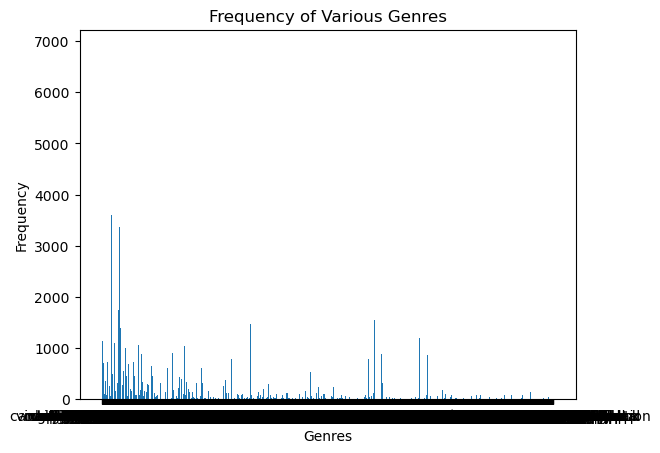

In [18]:
import matplotlib.pyplot as plt

# Plot the frequency distribution
plt.bar(genre_dict.keys(), genre_dict.values())
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.title('Frequency of Various Genres')
plt.show()

In [19]:
genres_df = pd.Series(genre_dict)
genres_df.head()

album rock         958
classic rock      1359
heartland rock     101
mellow gold       1142
piano rock         237
dtype: int64

In [20]:
# Summary Statistics of genres.
genres_df.T.describe()

count    4229.000000
mean      130.134074
std       393.314582
min         1.000000
25%         4.000000
50%        19.000000
75%        85.000000
max      6880.000000
dtype: float64

In [21]:
# genres_df.to_csv("data/genre_frequency.csv")

In [22]:
# Frequency tabulation of all superset genres. With priority given to the input song.

from collections import defaultdict

def group_into_supersets(genre_dict):
    supersets = defaultdict(int)

    for genre, frequency in genre_dict.items():
        matched = False
        for superset in supersets:
            if any(subset in genre for subset in superset.split()):
                supersets[superset] += frequency
                matched = True
                break
        if not matched:
            supersets[genre] += frequency

    return supersets

# Group into supersets
supersets = group_into_supersets(genre_dict)

# Output the result
for superset, frequency in supersets.items():
    print(f"{superset}: {frequency}")

album rock: 69873
mellow gold: 2278
singer-songwriter: 3542
british invasion: 1387
merseybeat: 529
classic uk pop: 158372
adult standards: 1219
lounge: 343
easy listening: 144
canadian blues: 2454
lilith: 307
folk: 6849
harlem renaissance: 46
big band: 3086
stride: 75
cool jazz: 5521
swing: 697
contemporary post-bop: 2611
italian soundtrack: 4359
hard bop: 2208
motown: 177
soul: 3119
beatlesque: 95
cabaret: 175
freakbeat: 40
protopunk: 50
oklahoma country: 3036
experimental: 191
late romantic era: 5129
orchestral performance: 575
french orchestra: 3983
compositional ambient: 435
funk: 2850
nashville sound: 397
permanent wave: 1875
alternative metal: 18198
post-grunge: 615
rap: 27106
detroit hip hop: 33560
ancient mediterranean: 653
reggae fusion: 8651
hyphy: 65
wrestling: 113
eurodance: 745
zolo: 34
post-punk: 272
miami indie: 11996
industrial techno: 1360
minimal dub: 368
brostep: 166
bassline: 72
edm: 5123
electro house: 15687
old school dancehall: 1241
ragga jungle: 206
ska: 1588
re

In [23]:
print(len(supersets.keys()))

358


In [24]:
# Creating the genre supersets, with priority to the input song's genre.
# Since the input song is the first one to be run, its genre will be able to start the classification of other sub-genres under it.

# This can be further improved. Allowing for later genres to take over earlier genres as the superset if it more general.
# E.g.: Detroit Hip Hop is found before general hip hop. Currently they will be seperated into 2 seperate genres because the first word 'detroit' is
# not 'hip hop' and is thus overlooked.

def generate_superset_mapping(genre_dict):
    superset_mapping = {}

    for genre, frequency in genre_dict.items():
        superset_found = False
        for superset in superset_mapping:
            if any(subset in genre for subset in superset_mapping[superset]):
                superset_mapping[superset].append(genre)
                superset_found = True
                break
        if not superset_found:
            superset_mapping[genre] = [genre]

    return superset_mapping

# Generate superset mapping
superset_mapping = generate_superset_mapping(genre_dict)

# Output the superset mapping
for superset, subsets in superset_mapping.items():
    print(f"{superset}: {subsets}")

album rock: ['album rock']
classic rock: ['classic rock', 'mexican classic rock']
heartland rock: ['heartland rock']
mellow gold: ['mellow gold']
piano rock: ['piano rock']
rock: ['rock', 'soft rock', 'folk rock', 'rock-and-roll', 'rockabilly', 'psychedelic rock', 'roots rock', 'acid rock', 'hard rock', 'symphonic rock', 'art rock', 'country rock', 'blues rock', 'australian rock', 'pub rock', 'classic garage rock', 'pop rock', 'british alternative rock', 'dance rock', 'irish rock', 'rock steady', 'lovers rock', 'rock goiano', 'peruvian rock', 'latin rock', 'rock en espanol', 'spanish pop rock', 'kindie rock', 'celtic rock', 'brazilian rock', 'modern rock', 'alternative rock', 'indie rock', 'medieval rock', 'garage rock', 'garage rock revival', 'swedish garage rock', 'swedish hard rock', 'swedish indie rock', 'rap rock', 'romanian rock', 'rock nacional brasileiro', 'argentine rock', 'rock nacional', 'australian alternative rock', 'industrial rock', 'canadian rock', 'modern country rock'

In [25]:
# Now with the superset mapped out, apply it onto the all the songs to determine their supersetted genre(s).
# This can be improved. Instead of only returning the first superset genre, it should return multiple in an array.

import pandas as pd

genres_df = pd.DataFrame(genres_df, columns=['genres'])

def group_into_supersets(new_df, superset_mapping):
    def get_superset(genres):
        for superset, subsets in superset_mapping.items():
            if any(subset in genre for genre in genres for subset in subsets):
                return superset
        return 'other'  # If no superset is found

    new_df['supersetted_genres'] = new_df['genres'].apply(get_superset)
    return new_df

# Group into supersets and create new column
new_df = group_into_supersets(new_df, superset_mapping)

In [26]:
new_df['supersetted_genres'].value_counts().count()

893

### Encoding

In [27]:
# One-hot Encoding of all the superset genres of each song in the dataframe.

genres_dummies = pd.get_dummies(new_df['supersetted_genres'].apply(pd.Series).stack()).groupby(level=0).sum()

# Concatenate the binary columns with the original DataFrame
df_2 = pd.concat([new_df, genres_dummies], axis=1)

In [28]:
# Removing unnecessary features.

df_2 = df_2.drop(['id_artists', 'release_date', 'popularity', 'mode', 'artists_count', 'song_name_artist', 'artist_1', 'artist_2', 'artist_3', 'artist_4', 'genres', 'supersetted_genres'], axis=1)
df_2.head()

,id,name,duration_ms,explicit,artists,danceability,energy,key,loudness,speechiness,...,yoga,zen,zespol dzieciecy,zhongguo feng,zikir,zillertal,zim urban groove,zolo,zouglou,zouk
0,70C4NyhjD5OZUMzvWZ3njJ,Piano Man,339000,0,[Billy Joel],0.331,0.550,0,-6.483,0.0272,...,0,0,0,0,0,0,0,0,0,0
1,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,160187,0,NaN,0.484,0.265,0,-11.101,0.0322,...,0,0,0,0,0,0,0,0,0,0
4,4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,141987,0,NaN,0.405,0.365,6,-10.226,0.0289,...,0,0,0,0,0,0,0,0,0,0
5,0ZMMtH875IR2TfkyC4PolD,Don't Let the Sun Catch You Crying (Main) - Mono,157093,0,NaN,0.477,0.352,1,-14.165,0.0300,...,0,0,0,0,0,0,0,0,0,0
6,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,187333,0,NaN,0.319,0.201,7,-17.796,0.0623,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Filling in any null values. (In case)

df_2 = df_2.fillna(0)
df_2.head()

,id,name,duration_ms,explicit,artists,danceability,energy,key,loudness,speechiness,...,yoga,zen,zespol dzieciecy,zhongguo feng,zikir,zillertal,zim urban groove,zolo,zouglou,zouk
0,70C4NyhjD5OZUMzvWZ3njJ,Piano Man,339000,0,[Billy Joel],0.331,0.550,0,-6.483,0.0272,...,0,0,0,0,0,0,0,0,0,0
1,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,160187,0,0,0.484,0.265,0,-11.101,0.0322,...,0,0,0,0,0,0,0,0,0,0
4,4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,141987,0,0,0.405,0.365,6,-10.226,0.0289,...,0,0,0,0,0,0,0,0,0,0
5,0ZMMtH875IR2TfkyC4PolD,Don't Let the Sun Catch You Crying (Main) - Mono,157093,0,0,0.477,0.352,1,-14.165,0.0300,...,0,0,0,0,0,0,0,0,0,0
6,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,187333,0,0,0.319,0.201,7,-17.796,0.0623,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_2.shape

(166252, 912)

### Cosine Similarity & Output Extraction

In [31]:
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

# Feature selection, removing non-useful rows.
def processing(df_2):
    # Normalize numerical features
    numerical_features = ['duration_ms', 'loudness', 'tempo']
    scaler = MinMaxScaler()
    df_2[numerical_features] = scaler.fit_transform(df_2[numerical_features])
    
    # Standardize Year
    df_2['standardized_year'] = scaler.fit_transform(df_2[['year']])
    df_2 = df_2.drop(['year'], axis=1)

    # Create a feature matrix
    feature_matrix = df_2.drop(['id', 'name', 'artists', 'song_id_name', 'explicit', 'time_signature'], axis=1)

    # Apply normalization to the entire feature matrix
    feature_matrix = scaler.fit_transform(feature_matrix)

    # This is the input song. We are isolating it from the dataframe first.
    input_song = feature_matrix[0]
    
    arr = []

    # Returns comparison value of first song in dataset to all others in an array.
    # DataFrame can be customized before Feature Selection to change which song the subject of comparison should be.
    for i in range(1, len(feature_matrix)):
        # Take the i-th song from the feature matrix
        compare_song = feature_matrix[i]
        # Perform cosine similarity.
        cosine_sim = cosine_similarity([input_song], [compare_song])
        cs_value = cosine_sim[0][0]  # Take the single similarity value between the input song and the i-th song.
        arr.append(cs_value)

    return arr

arr = processing(df_2)
arr

[0.5716840651821083,
 0.5496750153794498,
 0.5818916975024888,
 0.5038721922651996,
 0.47131080959009564,
 0.5965918322061741,
 0.6092616422091341,
 0.6109393958880038,
 0.5663188910648915,
 0.5956953309062016,
 0.5844240145711543,
 0.6040709295019049,
 0.6244681135379202,
 0.5944631548742877,
 0.5151188519946638,
 0.5564652719579661,
 0.570310310590978,
 0.5522884118549508,
 0.5269760657407996,
 0.4906113117672735,
 0.5339359678800142,
 0.5413039502695054,
 0.5869184860890032,
 0.48463916711181765,
 0.5764434744911957,
 0.5420170632647195,
 0.4996444516331291,
 0.48998639317597414,
 0.56588556667865,
 0.5337492567434463,
 0.48574012708414255,
 0.5589637178598927,
 0.6552286690890788,
 0.5839491670784425,
 0.5194256034843392,
 0.5336288006013905,
 0.5595366272849995,
 0.6324251743943519,
 0.6196572621442383,
 0.63130857595204,
 0.519733807019481,
 0.593996716023256,
 0.7854201254989807,
 0.5731497421206038,
 0.5097923903066333,
 0.6309111486854307,
 0.6286418833953261,
 0.5819802167183

In [32]:
max(arr[1:])

0.9243067034058043

In [33]:
def compile_suggestions(arr):
    suggestions = []
    
    # Compiling all song ids that are above the pre-determined threshold for 'like the first song'.
    for i in range(len(arr)):
        if arr[i] > 0.9:
            suggestions.append(i)
    
    print(suggestions)
    return suggestions
suggestions = compile_suggestions(arr)

[4189, 22779, 33900, 34568, 35105, 41907, 58321, 80102, 141108, 147672, 161483]


In [34]:
len(suggestions)

11

In [35]:
# Extracting out the end result information.
df_main = df_2[df_2.index.isin(suggestions)]

df_main.head()

,id,name,duration_ms,explicit,artists,danceability,energy,key,loudness,speechiness,...,zen,zespol dzieciecy,zhongguo feng,zikir,zillertal,zim urban groove,zolo,zouglou,zouk,standardized_year
22779,4YhxuvYRcICPmiKPC7npj3,Psychotic Night,0.047228,0,0,0.345,0.981,11,0.841585,0.1980,...,0,0,0,0,0,0,0,0,0,0.666667
33900,1fg6pmWO7Tv0ZkltlrAIkW,Like an Angel - 2012 Remaster,0.037767,0,0,0.512,0.766,2,0.879467,0.0302,...,0,0,0,0,0,0,0,0,0,0.812500
35105,71P8S4eUjQXJ7nAlRHXCSW,Tiempo De Comenzar,0.056337,0,0,0.625,0.668,10,0.875107,0.0304,...,0,0,0,0,0,0,0,0,0,0.562500
41907,69ZRVsGoLXjHrQWHMX5iCN,Sons of Plunder,0.044706,0,0,0.544,0.987,11,0.902106,0.0489,...,0,0,0,0,0,0,0,0,0,0.666667
58321,1mqhGHbmZic5lKAIfNudm5,Vallenato Reggae,0.049490,0,0,0.786,0.827,1,0.892895,0.0773,...,0,0,0,0,0,0,0,0,0,0.666667


In [41]:
len(df_main) # There is one less for the last 3 features as the input song did not go through the extracted year's steps.
# df_final['standardized_year'].describe()

8

In [37]:
df_main = df_main.iloc[1:]

df_main = df_main.drop('artists', axis=1)

id_artist_mapping = df.set_index('id')['artists'].to_dict()

# Add 'artist' column to df1 using the mapping
df_main['artists'] = df_main['id'].map(id_artist_mapping)
df_main.head()

,id,name,duration_ms,explicit,danceability,energy,key,loudness,speechiness,acousticness,...,zespol dzieciecy,zhongguo feng,zikir,zillertal,zim urban groove,zolo,zouglou,zouk,standardized_year,artists
33900,1fg6pmWO7Tv0ZkltlrAIkW,Like an Angel - 2012 Remaster,0.037767,0,0.512,0.766,2,0.879467,0.0302,0.270000,...,0,0,0,0,0,0,0,0,0.812500,['Dalton']
35105,71P8S4eUjQXJ7nAlRHXCSW,Tiempo De Comenzar,0.056337,0,0.625,0.668,10,0.875107,0.0304,0.303000,...,0,0,0,0,0,0,0,0,0.562500,['Binomio de Oro de América']
41907,69ZRVsGoLXjHrQWHMX5iCN,Sons of Plunder,0.044706,0,0.544,0.987,11,0.902106,0.0489,0.000071,...,0,0,0,0,0,0,0,0,0.666667,['Disturbed']
58321,1mqhGHbmZic5lKAIfNudm5,Vallenato Reggae,0.049490,0,0.786,0.827,1,0.892895,0.0773,0.450000,...,0,0,0,0,0,0,0,0,0.666667,"['Luifer Cuello', 'Manuel Julián']"
80102,0bz0nJ3SztnFRKfSwFbhC6,My Everything,0.045342,0,0.637,0.523,4,0.830464,0.0326,0.296000,...,0,0,0,0,0,0,0,0,0.562500,['98º']


### Recommendations Output

In [43]:
# Generating recc_num of the matched songs at random.
def recommend(df_main, recc_num):
    recs = []
    if len(df_main) == 0:
        print("Sorry! There are no songs similar enough to " + input_song + "!")
    elif len(df_main) < recc_num:
        recc_num = len(df_main)
        print("Uh oh! We only found " + str(recc_num) + " recommendations!")
    print('Here are your recommendations!')
    for c in range(recc_num):
        recc = df_main.sample().to_dict()
        name = list(recc['name'].values())[0]
        artists = (list(recc['artists'].values())[0])[1:len(list(recc['artists'].values())[0])-1]
        year = str(list(recc['year'].values())[0])
        print(str(c + 1) + '. ' + name + ' by ' + artists + ' published in ' + year)
        df_main = df_main.drop(list(recc['id'])[0])
        recs.append((name, year))
    return recs
# May want to try a filter for repreventing duplicate songs in the list.
recs_for_user = recommend(df_main, recc_num) # End Product

Uh oh! We only found 8 recommendations!
Here are your recommendations!
1. Sons of Plunder by 'Disturbed' published in 2005
2. Vallenato Reggae by 'Luifer Cuello', 'Manuel Julián' published in 2005
3. Il Mestiere Della Vita by 'Tiziano Ferro' published in 2016
4. Like an Angel - 2012 Remaster by 'Dalton' published in 2012
5. Tiempo De Comenzar by 'Binomio de Oro de América' published in 2000
6. My Everything by '98º' published in 2000
7. Senhor, Preciso de Ti (Lord, I Need You) by 'Paulo Cesar Baruk' published in 2015
8. 當愛已成往事 by 'Jonathan Lee', 'Fish Leong' published in 2007


In [44]:
user_id = sp.current_user()["id"]
song_uris = []
for song in recs_for_user:
    result = sp.search(q=f"track:{song[0]} year:{song[1]}", type="track")
    print(result)
    try:
        uri = result["tracks"]["items"][0]["uri"]
        song_uris.append(uri)
    except IndexError:
        print(f"{song[0]} doesn't exist in Spotify. Skipped.")

playlist = sp.user_playlist_create(user=user_id, name=input_playlist, public=False)
sp.playlist_add_items(playlist_id=playlist["id"], items=song_uris)

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3ASons+of+Plunder+year%3A2005&type=track&offset=0&limit=10', 'items': [{'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3TOqt5oJwL9BE2NG9MEwDa'}, 'href': 'https://api.spotify.com/v1/artists/3TOqt5oJwL9BE2NG9MEwDa', 'id': '3TOqt5oJwL9BE2NG9MEwDa', 'name': 'Disturbed', 'type': 'artist', 'uri': 'spotify:artist:3TOqt5oJwL9BE2NG9MEwDa'}], 'available_markets': ['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DK', 'DO', 'DE', 'EC', 'EE', 'SV', 'FI', 'FR', 'GR', 'GT', 'HN', 'HK', 'HU', 'IS', 'IE', 'IT', 'LV', 'LT', 'LU', 'MY', 'MT', 'MX', 'NL', 'NZ', 'NI', 'NO', 'PA', 'PY', 'PE', 'PH', 'PL', 'PT', 'SG', 'SK', 'ES', 'SE', 'CH', 'TW', 'TR', 'UY', 'US', 'GB', 'AD', 'LI', 'MC', 'ID', 'JP', 'TH', 'VN', 'RO', 'IL', 'ZA', 'SA', 'AE', 'BH', 'QA', 'OM', 'KW', 'EG', 'MA', 'DZ', 'TN', 'LB', 'JO', 'PS', 'IN', 'BY', 'KZ', 'MD', 'UA', 'AL', 'BA', 'HR',

{'snapshot_id': 'Miw1NWZmY2QyZTgwNDg5NmZmM2E3MzQ0YTY5M2QxYTYyMjk2ZmI2ODRm'}